# Starting cluster

## Prerequisites
First, you need to install MPI, on windows use MS-MPI:
https://msdn.microsoft.com/en-us/library/bb524831(v=vs.85).aspx


## With a profile (not working)
In theory, you should be able to create a profile using
```
ipython profile create --parallel --profile=myprofile
```
and then set
```
c.IPClusterEngines.engine_launcher_class = 'MPIEngineSetLauncher'
```
in ```<IPYTHON-DIR>/profile_myprofile/ipcluster_config.py```. This should then enable you to start a cluster using
```
ipcluster start --profile=myprofile
```
or alternatively through the Clusters tab in Jupyter


## Without a profile (not working)
An alternative is to run
```
ipcluster start --engines=MPI
```


## Manual start (working)
This, however, does *not* work for me on Windows. What does work is the following:

Start a controller using
```
ipcontroller --ip='*'
```
and then start several engines using mpiexec:
```
mpiexec -n 4 ipengine --mpi
```

In [1]:
from GPUSimulators import IPythonMagic

In [2]:
%setup_logging --out mpi.log my_logger

Console logger using level INFO
File logger using level DEBUG to mpi.log
Python version 3.6.9 |Anaconda, Inc.| (default, Jul 30 2019, 14:00:49) [MSC v.1915 64 bit (AMD64)]


In [3]:
%setup_mpi mpi_context --num_engines 3

Starting IPController
Starting IPEngines
Waiting for cluster...
Waiting for cluster...
Waiting for cluster...
Waiting for cluster...
Waiting for cluster...
Waiting for cluster...
Waiting for cluster...
Waiting for cluster...
Done


In [4]:
%%px

%matplotlib inline

import numpy as np
from matplotlib import pyplot as plt
from mpi4py import MPI
import time
import json

from GPUSimulators import IPythonMagic, MPISimulator, Common

In [5]:
%%px
%setup_logging --out "'mpi_' + str(MPI.COMM_WORLD.rank) + '.log'" my_logger

[stderr:0] 
Console logger using level INFO
File logger using level DEBUG to mpi_0.log
Python version 3.6.9 |Anaconda, Inc.| (default, Jul 30 2019, 14:00:49) [MSC v.1915 64 bit (AMD64)]
[stderr:1] 
Console logger using level INFO
File logger using level DEBUG to mpi_1.log
Python version 3.6.9 |Anaconda, Inc.| (default, Jul 30 2019, 14:00:49) [MSC v.1915 64 bit (AMD64)]
[stderr:2] 
Console logger using level INFO
File logger using level DEBUG to mpi_2.log
Python version 3.6.9 |Anaconda, Inc.| (default, Jul 30 2019, 14:00:49) [MSC v.1915 64 bit (AMD64)]


In [6]:
%%px
%cuda_context_handler my_context

[stderr:0] 
Registering my_context in user workspace
PyCUDA version 2018.1.1
CUDA version (10, 0, 0)
Driver version 10000
Using device 0/1 'GeForce 840M' (0000:03:00.0) GPU
Created context handle <650919533984>
Using CUDA cache dir C:\Users\anbro\Documents\projects\GPUSimulators\GPUSimulators\cuda_cache
Autotuning enabled. It may take several minutes to run the code the first time: have patience
[stderr:1] 
Registering my_context in user workspace
PyCUDA version 2018.1.1
CUDA version (10, 0, 0)
Driver version 10000
Using device 0/1 'GeForce 840M' (0000:03:00.0) GPU
Created context handle <669212383056>
Using CUDA cache dir C:\Users\anbro\Documents\projects\GPUSimulators\GPUSimulators\cuda_cache
Autotuning enabled. It may take several minutes to run the code the first time: have patience
[stderr:2] 
Registering my_context in user workspace
PyCUDA version 2018.1.1
CUDA version (10, 0, 0)
Driver version 10000
Using device 0/1 'GeForce 840M' (0000:03:00.0) GPU
Created context handle <55369

In [7]:
%%px

def plotExtent(extent, *args, **kwargs):
    x0, x1, y0, y1 = extent
    plt.plot([x0, x1, x1, x0, x0], [y0, y0, y1, y1, y0], *args, **kwargs)

In [8]:
%%px

import importlib
importlib.reload(MPISimulator)

grid = MPISimulator.MPIGrid(MPI.COMM_WORLD)
print(grid.getLocalRank())

[stdout:0] 0
[stdout:1] 1
[stdout:2] 2


In [9]:
%%px

from GPUSimulators.helpers import InitialConditions
from GPUSimulators.Simulator import BoundaryCondition

my_context.autotuner = None

nx = 128
ny = 128
gamma = 1.4
save_times = np.linspace(0, 5.0, 10)
outfile = "mpi_out_" + str(MPI.COMM_WORLD.rank) + ".nc"
save_var_names = ['rho', 'rho_u', 'rho_v', 'E']


grid = MPISimulator.MPIGrid(MPI.COMM_WORLD)
print(grid.getLocalRank())

#arguments = InitialConditions.genShockBubble(nx, ny, gamma, grid=grid)
arguments = InitialConditions.genKelvinHelmholtz(nx, ny, gamma, grid=grid)
#arguments = InitialConditions.genRayleighTaylor(nx, ny, gamma, grid=grid)

arguments['context'] = my_context
arguments['theta'] = 1.2
arguments['grid'] = grid

from GPUSimulators import EE2D_KP07_dimsplit

def genSim(grid, **kwargs):
    local_sim = EE2D_KP07_dimsplit.EE2D_KP07_dimsplit(**kwargs)
    sim = MPISimulator.MPISimulator(local_sim, grid)
    return sim


outfile = Common.runSimulation(genSim, arguments, outfile, save_times, save_var_names)

[stdout:0] 0
[stdout:1] 1
[stdout:2] 2


[stderr:0] 
Constructed in 3.840158462524414 seconds
Initialized C:\Users\anbro\Documents\projects\GPUSimulators\mpi_out_0_0012.nc
Opening C:\Users\anbro\Documents\projects\GPUSimulators\mpi_out_0_0012.nc
Keyword arguments: {'mode': 'w', 'clobber': False}
JSON: Converting boundary_conditions to string ([north=Type.Periodic, south=Type.Periodic, east=Type.Periodic, west=Type.Periodic])
JSON: Converting context to string (CudaContext id 650919533984)
JSON: Converting grid to string (<GPUSimulators.MPISimulator.MPIGrid object at 0x000000979166F4A8>)
MPISimulator [128x128]: 0% [####==========================] 100%. Total: 33s, elapsed: 5s, remaining: 28s
MPISimulator [128x128]: 0% [##########################====] 100%. Total: 11s, elapsed: 10s, remaining: 1s
MPISimulator [128x128]: 0% [############==================] 100%. Total: 12s, elapsed: 5s, remaining: 7s
MPISimulator [128x128]: 0% [########################======] 100%. Total: 12s, elapsed: 10s, remaining: 2s
MPISimulator [128x128]: 

[stdout:0] 
C:\Users\anbro\Documents\projects\GPUSimulators\mpi_out_0_0012.nc created Mon Aug 12 13:52:30 2019 contains 10 timesteps
Simulator arguments: 
 {'rho': '[...]', 'rho_u': '[...]', 'rho_v': '[...]', 'E': '[...]', 'nx': 128, 'ny': 128, 'dx': 0.005208333333333333, 'dy': 0.0078125, 'g': 0.0, 'gamma': 1.4, 'boundary_conditions': '[north=Type.Periodic, south=Type.Periodic, east=Type.Periodic, west=Type.Periodic]', 'context': 'CudaContext id 650919533984', 'theta': 1.2, 'grid': '<GPUSimulators.MPISimulator.MPIGrid object at 0x000000979166F4A8>'}
[stdout:1] 
C:\Users\anbro\Documents\projects\GPUSimulators\mpi_out_1_0012.nc created Mon Aug 12 13:52:29 2019 contains 10 timesteps
Simulator arguments: 
 {'rho': '[...]', 'rho_u': '[...]', 'rho_v': '[...]', 'E': '[...]', 'nx': 128, 'ny': 128, 'dx': 0.005208333333333333, 'dy': 0.0078125, 'g': 0.0, 'gamma': 1.4, 'boundary_conditions': '[north=Type.Periodic, south=Type.Periodic, east=Type.Periodic, west=Type.Periodic]', 'context': 'CudaConte

[stderr:0] 
Initialized C:\Users\anbro\Documents\projects\GPUSimulators\mpi_out_0_0012.nc
Opening C:\Users\anbro\Documents\projects\GPUSimulators\mpi_out_0_0012.nc
Arguments: ('r',)
Closing C:\Users\anbro\Documents\projects\GPUSimulators\mpi_out_0_0012.nc
[stderr:1] 
Initialized C:\Users\anbro\Documents\projects\GPUSimulators\mpi_out_1_0012.nc
Opening C:\Users\anbro\Documents\projects\GPUSimulators\mpi_out_1_0012.nc
Arguments: ('r',)
Closing C:\Users\anbro\Documents\projects\GPUSimulators\mpi_out_1_0012.nc
[stderr:2] 
Initialized C:\Users\anbro\Documents\projects\GPUSimulators\mpi_out_2_0004.nc
Opening C:\Users\anbro\Documents\projects\GPUSimulators\mpi_out_2_0004.nc
Arguments: ('r',)
Closing C:\Users\anbro\Documents\projects\GPUSimulators\mpi_out_2_0004.nc


[output:0]

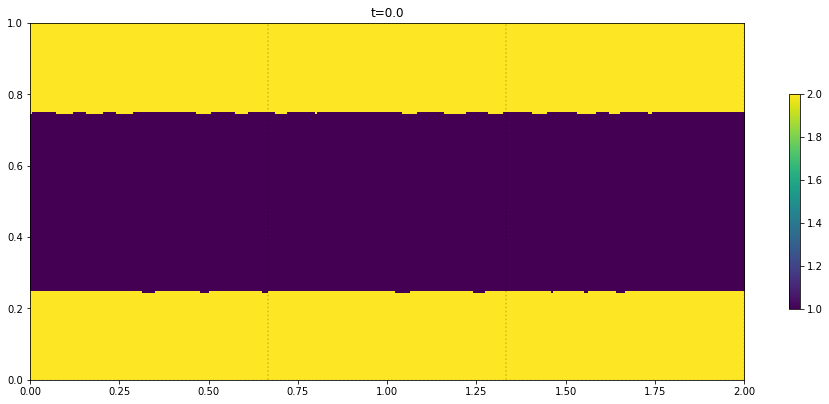

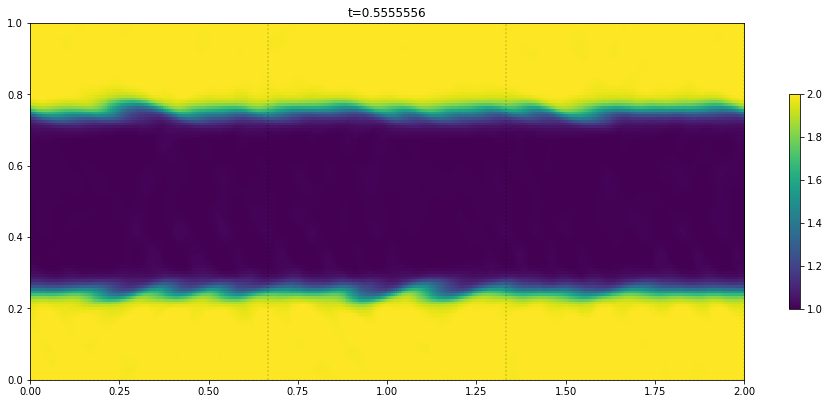

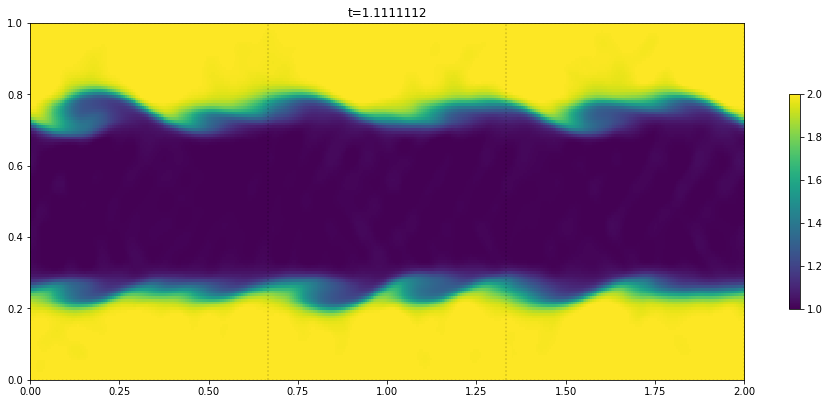

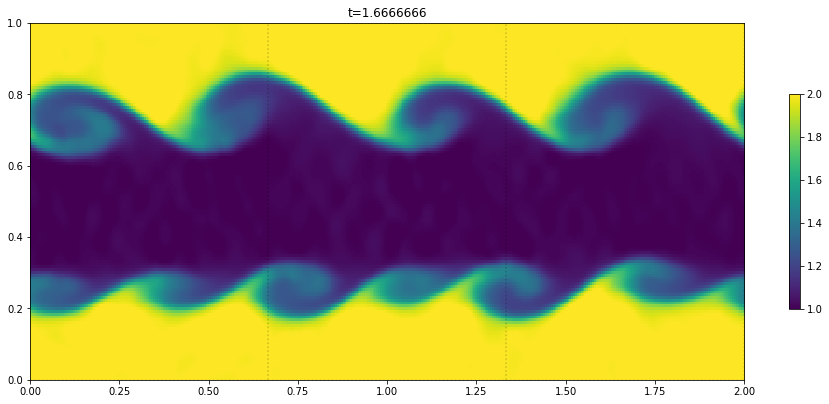

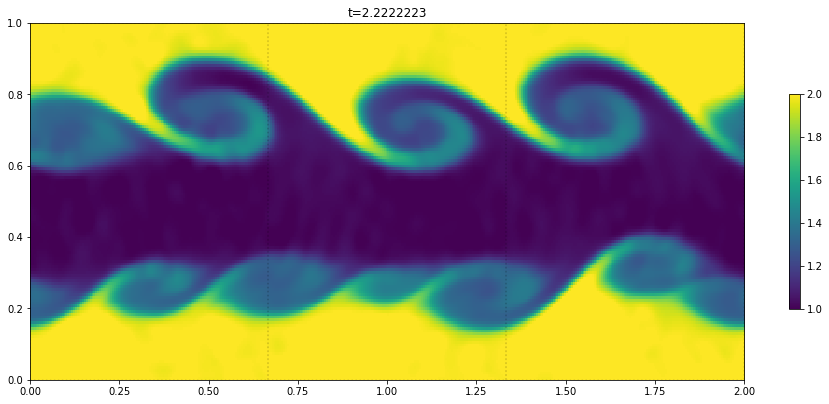

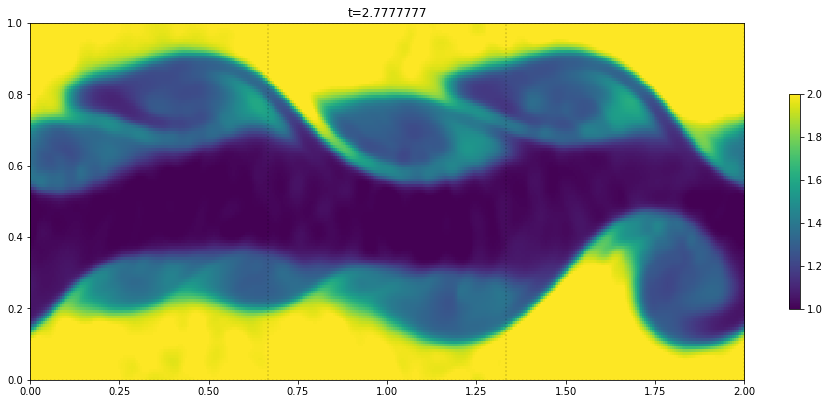

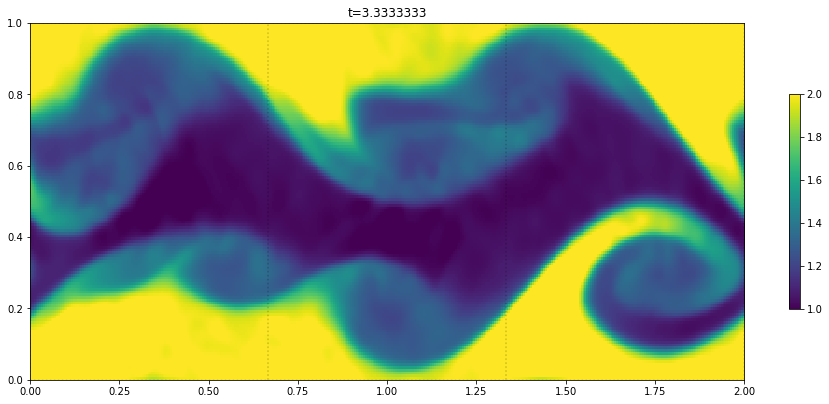

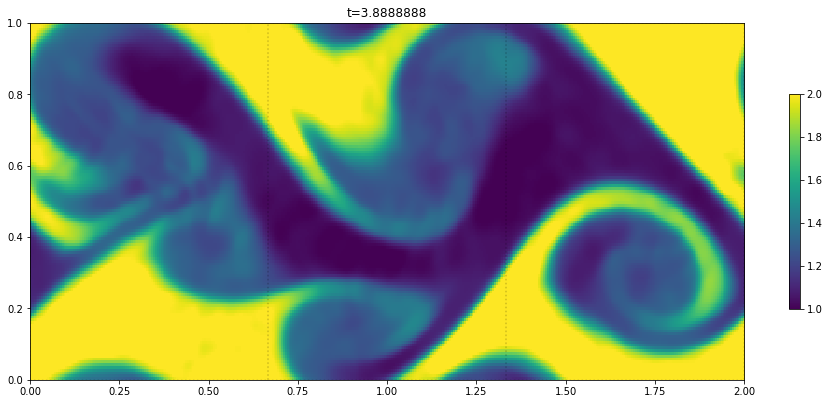

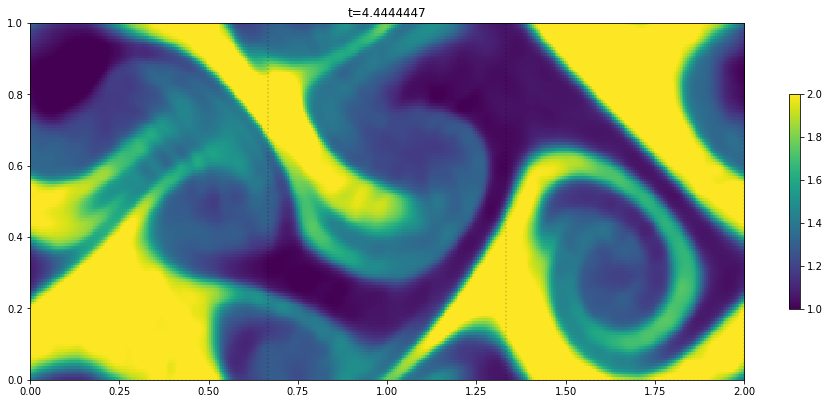

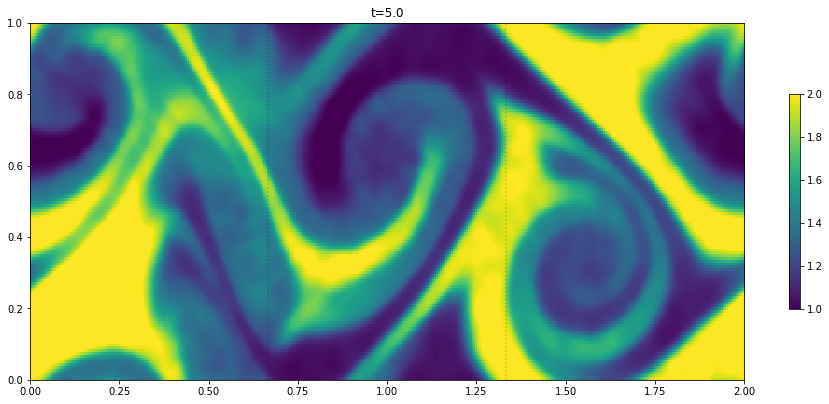

In [10]:
%%px

with Common.DataDumper(outfile, 'r') as indata:
    t = indata.ncfile.variables['time'][:]
    x = indata.ncfile.variables['x'][:]
    y = indata.ncfile.variables['y'][:]
    
    x_data = grid.gather(x)
    y_data = grid.gather(y)
    
    created = indata.ncfile.created
    sim_args = json.loads(indata.ncfile.sim_args)
    for key in sim_args:
        if isinstance(sim_args[key], list):
            sim_args[key] = "[...]"
    num_steps = len(t)
    print("{:s} created {:s} contains {:d} timesteps".format(outfile, created, num_steps))
    print("Simulator arguments: \n", sim_args)
    
    
    for i in range(num_steps):
        rho = indata.ncfile.variables['rho'][i]
        rho_data = grid.gather(rho)
        
        #Plot on rank 0
        if (grid.comm.rank == 0):
            plt.figure(figsize=(16, 12))
            for k in range(grid.comm.size):
                extent = [x_data[k].min(), x_data[k].max(), y_data[k].min(), y_data[k].max()]
                plt.imshow(rho_data[k], extent=extent, origin='lower', vmin=1.0, vmax=2.0)
                plotExtent(extent, 'k:', alpha=0.1)
            plt.title("t=" + str(t[i]))
            plt.colorbar(shrink=0.33)

In [11]:
%%px

from GPUSimulators.helpers import InitialConditions
from GPUSimulators.Simulator import BoundaryCondition

nx = 128
ny = 128
g = 9.81
dt = 0.05
width = 50
height = 100
save_times = np.linspace(0, 80, 10)
outfile = "mpi_out_" + str(MPI.COMM_WORLD.rank) + ".nc"
save_var_names = ['h', 'hu', 'hv']


if (MPI.COMM_WORLD.rank == 0):
    h0, hu0, hv0, dx, dy = InitialConditions.bump(nx, ny, width, height, g, x_center=0.75, y_center=0.55)
else:
    h0, hu0, hv0, dx, dy = InitialConditions.bump(nx, ny, width, height, g, h_ref=0.5, h_amp=0.0, u_amp=0.0, v_amp=0.0)

bc = BoundaryCondition({
    'north': BoundaryCondition.Type.Reflective,
    'south': BoundaryCondition.Type.Reflective,
    'east': BoundaryCondition.Type.Reflective,
    'west': BoundaryCondition.Type.Reflective
})
grid = MPISimulator.MPIGrid(MPI.COMM_WORLD)

arguments = {
    'context': my_context,
    'h0': h0, 'hu0': hu0, 'hv0': hv0,
    'nx': nx, 'ny': ny,
    'dx': dx, 'dy': dy, 
    'g': g,
    'boundary_conditions': bc,
    'grid': grid
} 

from GPUSimulators import HLL2

def genSim(grid, **kwargs):
    local_sim = HLL2.HLL2(**kwargs)
    sim = MPISimulator.MPISimulator(local_sim, grid)
    return sim

outfile = Common.runSimulation(genSim, arguments, outfile, save_times, save_var_names)

[stderr:0] 
Constructed in 0.020514488220214844 seconds
Initialized C:\Users\anbro\Documents\projects\GPUSimulators\mpi_out_0_0013.nc
Opening C:\Users\anbro\Documents\projects\GPUSimulators\mpi_out_0_0013.nc
Keyword arguments: {'mode': 'w', 'clobber': False}
JSON: Converting context to string (CudaContext id 650919533984)
JSON: Converting boundary_conditions to string ([north=Type.Reflective, south=Type.Reflective, east=Type.Reflective, west=Type.Reflective])
JSON: Converting grid to string (<GPUSimulators.MPISimulator.MPIGrid object at 0x000000978BCC20F0>)
Closing C:\Users\anbro\Documents\projects\GPUSimulators\mpi_out_0_0013.nc
[stderr:1] 
Constructed in 0.05653858184814453 seconds
Initialized C:\Users\anbro\Documents\projects\GPUSimulators\mpi_out_1_0013.nc
Opening C:\Users\anbro\Documents\projects\GPUSimulators\mpi_out_1_0013.nc
Keyword arguments: {'mode': 'w', 'clobber': False}
JSON: Converting context to string (CudaContext id 669212383056)
JSON: Converting boundary_conditions to

[stdout:0] 
C:\Users\anbro\Documents\projects\GPUSimulators\mpi_out_0_0013.nc created Mon Aug 12 13:54:08 2019 contains 10 timesteps
Simulator arguments: 
 {'context': 'CudaContext id 650919533984', 'h0': '[...]', 'hu0': '[...]', 'hv0': '[...]', 'nx': 128, 'ny': 128, 'dx': 0.390625, 'dy': 0.78125, 'g': 9.81, 'boundary_conditions': '[north=Type.Reflective, south=Type.Reflective, east=Type.Reflective, west=Type.Reflective]', 'grid': '<GPUSimulators.MPISimulator.MPIGrid object at 0x000000978BCC20F0>'}
[stdout:1] 
C:\Users\anbro\Documents\projects\GPUSimulators\mpi_out_1_0013.nc created Mon Aug 12 13:54:08 2019 contains 10 timesteps
Simulator arguments: 
 {'context': 'CudaContext id 669212383056', 'h0': '[...]', 'hu0': '[...]', 'hv0': '[...]', 'nx': 128, 'ny': 128, 'dx': 0.390625, 'dy': 0.78125, 'g': 9.81, 'boundary_conditions': '[north=Type.Reflective, south=Type.Reflective, east=Type.Reflective, west=Type.Reflective]', 'grid': '<GPUSimulators.MPISimulator.MPIGrid object at 0x0000009BD5E2

[stderr:0] 
Initialized C:\Users\anbro\Documents\projects\GPUSimulators\mpi_out_0_0013.nc
Opening C:\Users\anbro\Documents\projects\GPUSimulators\mpi_out_0_0013.nc
Arguments: ('r',)
Closing C:\Users\anbro\Documents\projects\GPUSimulators\mpi_out_0_0013.nc
[stderr:1] 
Initialized C:\Users\anbro\Documents\projects\GPUSimulators\mpi_out_1_0013.nc
Opening C:\Users\anbro\Documents\projects\GPUSimulators\mpi_out_1_0013.nc
Arguments: ('r',)
Closing C:\Users\anbro\Documents\projects\GPUSimulators\mpi_out_1_0013.nc
[stderr:2] 
Initialized C:\Users\anbro\Documents\projects\GPUSimulators\mpi_out_2_0005.nc
Opening C:\Users\anbro\Documents\projects\GPUSimulators\mpi_out_2_0005.nc
Arguments: ('r',)
Closing C:\Users\anbro\Documents\projects\GPUSimulators\mpi_out_2_0005.nc


[output:0]

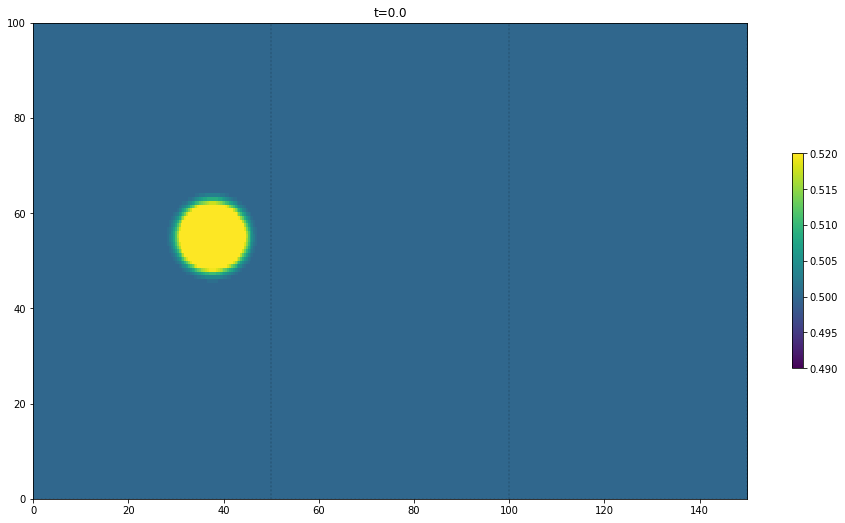

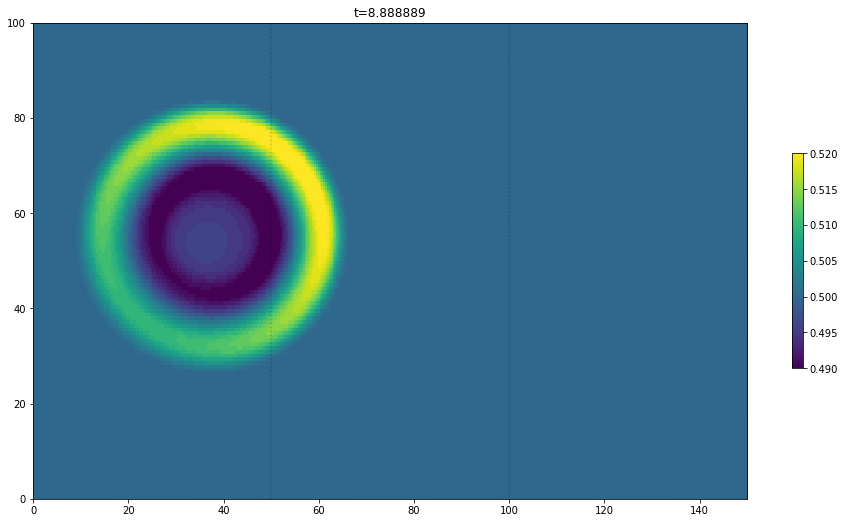

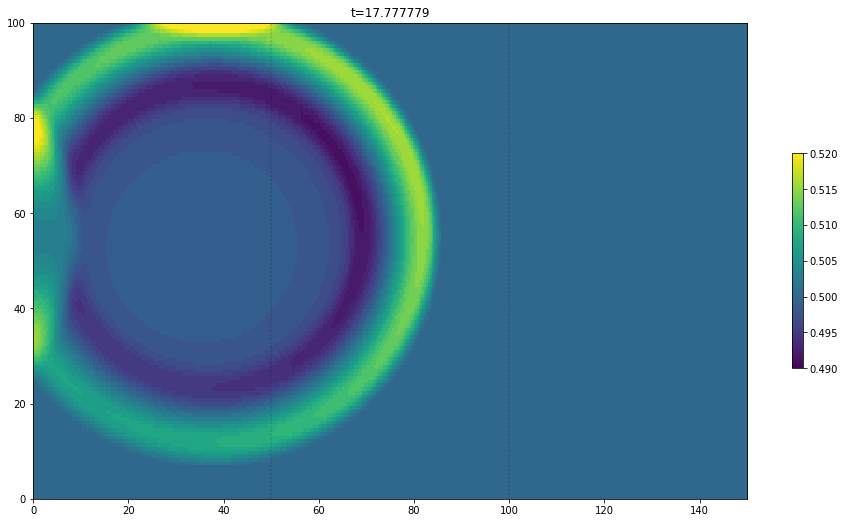

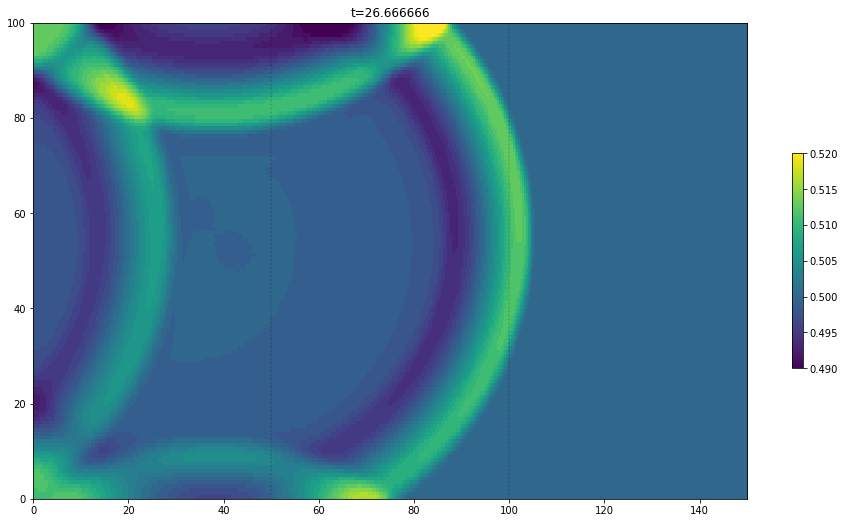

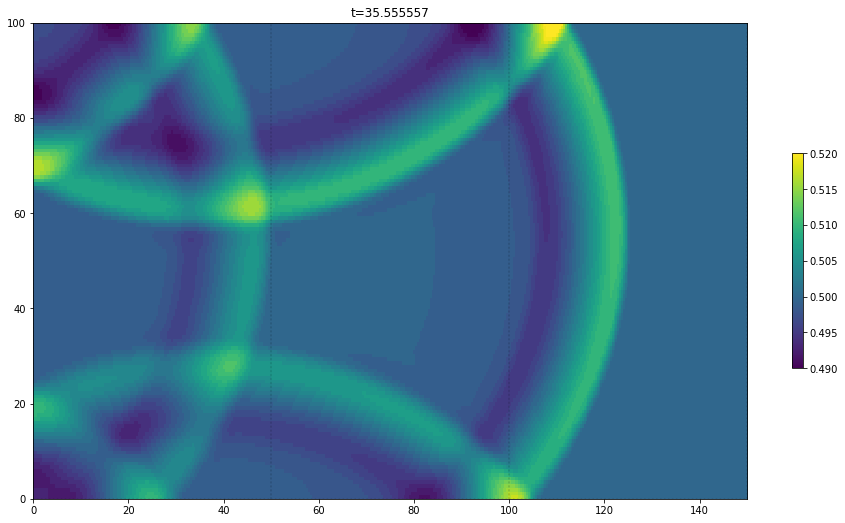

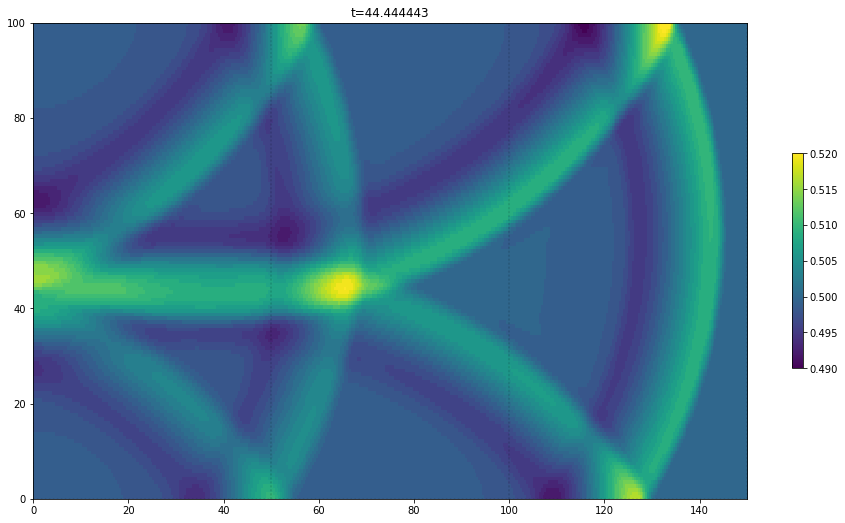

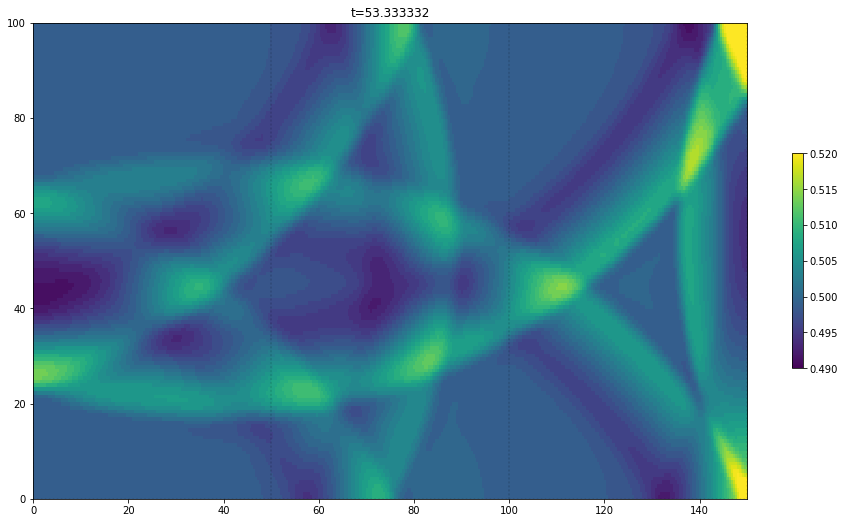

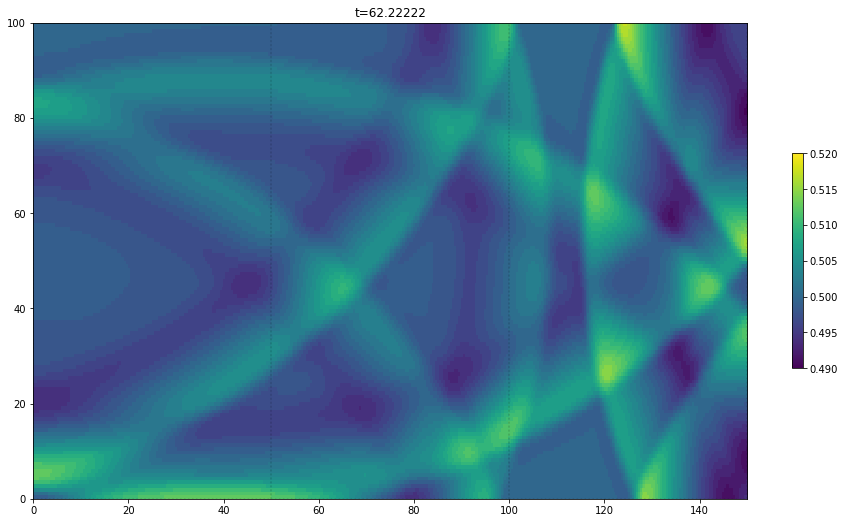

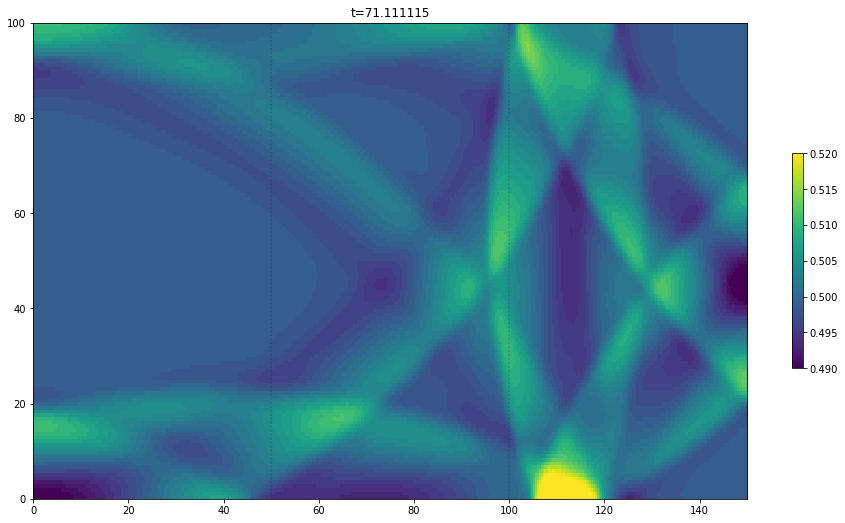

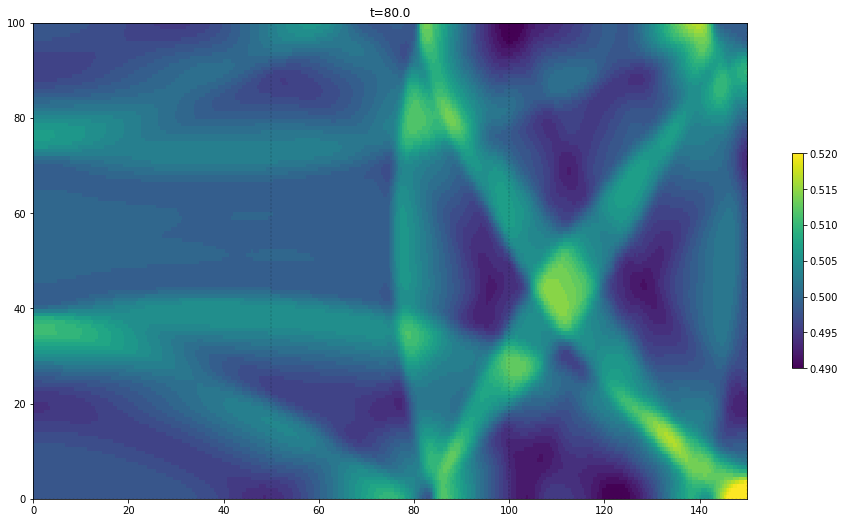

In [12]:
%%px

with Common.DataDumper(outfile, 'r') as indata:
    t = indata.ncfile.variables['time'][:]
    x = indata.ncfile.variables['x'][:]
    y = indata.ncfile.variables['y'][:]
    
    x_data = grid.gather(x)
    y_data = grid.gather(y)
    
    created = indata.ncfile.created
    sim_args = json.loads(indata.ncfile.sim_args)
    for key in sim_args:
        if isinstance(sim_args[key], list):
            sim_args[key] = "[...]"
    num_steps = len(t)
    print("{:s} created {:s} contains {:d} timesteps".format(outfile, created, num_steps))
    print("Simulator arguments: \n", sim_args)
    
    
    for i in range(num_steps):
        h = indata.ncfile.variables['h'][i]
        #hu = indata.ncfile.variables['hu'][i]
        #hv = indata.ncfile.variables['hv'][i]
        h_data = grid.gather(h)
        
        #Plot on rank 0
        if (grid.comm.rank == 0):
            plt.figure(figsize=(16, 12))
            for k in range(grid.comm.size):
                extent = [x_data[k].min(), x_data[k].max(), y_data[k].min(), y_data[k].max()]
                plt.imshow(h_data[k], extent=extent, origin='lower', vmin=0.49, vmax=0.52)
                plotExtent(extent, 'k:', alpha=0.1)
            plt.title("t=" + str(t[i]))
            plt.colorbar(shrink=0.33)